In [1]:
import pandas as pd

In [2]:
data_dir = ['./data/trial3/', './data/trial4/', './data/trial5/', './data/trial8/', './data/trial9/', './data/trial11/', './data/trial12/', './data/trial13/', './data/trial14/', './data/trial15/', './data/trial16/', './data/trial17/']

In [3]:
df = pd.DataFrame()
for location in data_dir:
    df_ = pd.read_csv(location+'driving_log.csv', names=['center_cam', 'left_cam', 'right_cam', 'steering', 'throttle', 'brake', 'speed'])
    # Rename data location
    df_.iloc[:,0:3] = df_.iloc[:,0:3].apply(lambda x: location + 'IMG/' + x.str.split('\\').str[-1])
    # Append to the training dataframe
    df = pd.concat([df,df_])

In [4]:
df.head()

,center_cam,left_cam,right_cam,steering,throttle,brake,speed
0,./data/trial3/IMG/center_2021_01_06_19_41_25_4...,./data/trial3/IMG/left_2021_01_06_19_41_25_443...,./data/trial3/IMG/right_2021_01_06_19_41_25_44...,0.0,0.0,0.0,0.000082
1,./data/trial3/IMG/center_2021_01_06_19_41_25_5...,./data/trial3/IMG/left_2021_01_06_19_41_25_546...,./data/trial3/IMG/right_2021_01_06_19_41_25_54...,0.0,0.0,0.0,0.000078
2,./data/trial3/IMG/center_2021_01_06_19_41_25_6...,./data/trial3/IMG/left_2021_01_06_19_41_25_649...,./data/trial3/IMG/right_2021_01_06_19_41_25_64...,0.0,0.0,0.0,0.000082
3,./data/trial3/IMG/center_2021_01_06_19_41_25_7...,./data/trial3/IMG/left_2021_01_06_19_41_25_752...,./data/trial3/IMG/right_2021_01_06_19_41_25_75...,0.0,0.0,0.0,0.000078
4,./data/trial3/IMG/center_2021_01_06_19_41_25_8...,./data/trial3/IMG/left_2021_01_06_19_41_25_857...,./data/trial3/IMG/right_2021_01_06_19_41_25_85...,0.0,0.0,0.0,0.000079


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39841 entries, 0 to 872
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   center_cam  39841 non-null  object 
 1   left_cam    39841 non-null  object 
 2   right_cam   39841 non-null  object 
 3   steering    39841 non-null  float64
 4   throttle    39841 non-null  float64
 5   brake       39841 non-null  float64
 6   speed       39841 non-null  float64
dtypes: float64(4), object(3)
memory usage: 2.4+ MB


In [6]:
df_clean = pd.DataFrame()
# Series with all camera angles
df_clean['camera'] = pd.concat([df['center_cam'], df['left_cam'], df['right_cam']])
# Series with all steering angels (and modified steering angles)
steering_offset = 0.02
df_clean['steering'] = pd.concat([
    df['steering'], 
    df['steering'].apply(lambda x: x + steering_offset),
    df['steering'].apply(lambda x: x - steering_offset)
    ])

df_clean.reset_index(drop=True, inplace=True);

In [7]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119523 entries, 0 to 119522
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   camera    119523 non-null  object 
 1   steering  119523 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Generator

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import cv2

In [10]:
# Constant preprocessing parameters
sample_img = mpimg.imread(df_clean['camera'][0])
scale_percent = 80 # percent of original size
width = int(sample_img.shape[1] * scale_percent / 100)
height = int(sample_img.shape[0] * scale_percent / 100)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def preprocess(image):
    '''
    Preprocesses a given RGB image for input into the model.
    :params image: RGB image as a numpy array
    '''
    normalized = image.copy()
    normalized[:,:,0] = clahe.apply(normalized[:,:,0])
    normalized[:,:,1] = clahe.apply(normalized[:,:,1])
    normalized[:,:,2] = clahe.apply(normalized[:,:,2])
    grayscale = cv2.cvtColor(normalized, cv2.COLOR_RGB2GRAY)
    downscaled = cv2.resize(grayscale, (width, height), interpolation=cv2.INTER_AREA)
    return downscaled

In [11]:
from tensorflow.keras.utils import Sequence

In [12]:
class Generator(Sequence):

    def __init__(self, samples, batch_size):
        self.samples = shuffle(samples)
        self.batch_size = batch_size

    def __len__(self):
        return np.ceil(len(self.samples) / self.batch_size).astype(np.int32)

    def __getitem__(self, idx):
        images = []
        angles = []
        # Read in images (and preprocess) and steering angles from the current batch
        self.samples['camera'][idx * self.batch_size:(idx + 1) *
        self.batch_size].apply(lambda x: images.append(preprocess(mpimg.imread(x))));
        self.samples['steering'][idx * self.batch_size:(idx + 1) *
        self.batch_size].apply(lambda x: angles.append(x));

        X_train = np.expand_dims(np.array(images), axis=3)
        y_train = np.array(angles)

        return tuple(shuffle(X_train, y_train))

In [13]:
# Split training and validation samples
train_samples, validation_samples = train_test_split(df_clean, test_size=0.2)

# Set batch size
batch_size=512

# compile and train the model using the generator function
train_generator = Generator(train_samples, batch_size)
validation_generator = Generator(validation_samples, batch_size)

# Training

In [14]:
import tensorflow as tf

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, Flatten, Dense, Conv2D, MaxPool2D, Dropout, Cropping2D  
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
tf.keras.backend.clear_session()

In [17]:
model = Sequential()
# Input Layer
model.add(Lambda(lambda x: x/255.0 -0.5, input_shape=(height, width, 1)))
model.add(Cropping2D(cropping=((40,10),(0,0))))
# Convolution 1
model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu'))
model.add(MaxPool2D(strides=(1,1)))
# Convolution 2
model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu'))
model.add(MaxPool2D(strides=(1,1)))
# Convolution 3
model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu'))
# Convolution 4
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(strides=(1,1)))
# Convolution 5
model.add(Conv2D(64, (3,3), activation='relu'))
# Flatten and Dropout
model.add(Flatten())
model.add(Dropout(0.25))
# Fully Connected 1
model.add(Dense(600, activation='relu'))
# Fully Connected 2
model.add(Dense(100, activation='relu'))
# Fully Connected 3 with Dropout
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
# Output
model.add(Dense(1));

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128, 256, 1)       0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 78, 256, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 37, 126, 24)       624       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 125, 24)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 61, 36)        21636     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 60, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 28, 48)         4

In [19]:
stopper = EarlyStopping(monitor='val_loss', min_delta=0.0003, patience=5)

In [20]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_generator, 
    steps_per_epoch=np.ceil(len(train_samples)/batch_size),
    validation_data=validation_generator,
    validation_steps=np.ceil(len(validation_samples)/batch_size),
    epochs=30,
    callbacks=[stopper])

Epoch 1/30
187/187 [==============================] - 180s 962ms/step - loss: 0.0557 - acc: 0.0499 - val_loss: 0.0413 - val_acc: 0.0506
Epoch 2/30
187/187 [==============================] - 163s 870ms/step - loss: 0.0402 - acc: 0.0509 - val_loss: 0.0354 - val_acc: 0.0514
Epoch 3/30
187/187 [==============================] - 161s 861ms/step - loss: 0.0355 - acc: 0.0515 - val_loss: 0.0307 - val_acc: 0.0516
Epoch 4/30
187/187 [==============================] - 161s 862ms/step - loss: 0.0321 - acc: 0.0517 - val_loss: 0.0268 - val_acc: 0.0522
Epoch 5/30
187/187 [==============================] - 160s 857ms/step - loss: 0.0291 - acc: 0.0520 - val_loss: 0.0251 - val_acc: 0.0522
Epoch 6/30
187/187 [==============================] - 161s 858ms/step - loss: 0.0275 - acc: 0.0521 - val_loss: 0.0242 - val_acc: 0.0523
Epoch 7/30
187/187 [==============================] - 161s 862ms/step - loss: 0.0267 - acc: 0.0523 - val_loss: 0.0229 - val_acc: 0.0523
Epoch 8/30
187/187 [============================

In [21]:
model.save('model.h5')

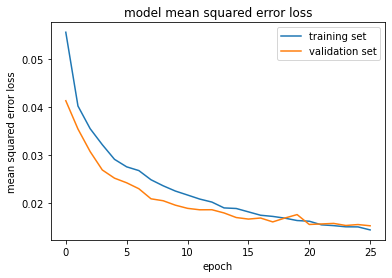

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [23]:
# y_train[400]

In [24]:
# model.predict(np.expand_dims(X_train_modified[400], axis=0))

In [25]:
# %run drive.py model.h5

# Fine-Tuning
Instead of re-training the network from scratch, this section can be modified to train on additional data.

In [45]:
from tensorflow.keras.models import load_model

In [53]:
# Load the model
model = load_model('model_tuned.h5')

In [54]:
# Load additional data
data_dir = ['./data/trial3/', './data/trial4/', './data/trial5/', './data/trial8/', './data/trial9/', './data/trial11/', './data/trial12/', './data/trial13/', './data/trial14/', './data/trial15/', './data/trial16/', './data/trial17/', './data/trial18/', './data/trial19/', './data/trial20/', './data/trial21/']

df = pd.DataFrame()
for location in data_dir:
    df_ = pd.read_csv(location+'driving_log.csv', names=['center_cam', 'left_cam', 'right_cam', 'steering', 'throttle', 'brake', 'speed'])
    # Rename data location
    df_.iloc[:,0:3] = df_.iloc[:,0:3].apply(lambda x: location + 'IMG/' + x.str.split('\\').str[-1])
    # Append to the training dataframe
    df = pd.concat([df,df_])

df_clean = pd.DataFrame()
# Series with all camera angles
df_clean['camera'] = pd.concat([df['center_cam'], df['left_cam'], df['right_cam']])
# Series with all steering angels (and modified steering angles)
steering_offset = 0.02
df_clean['steering'] = pd.concat([
    df['steering'], 
    df['steering'].apply(lambda x: x + steering_offset),
    df['steering'].apply(lambda x: x - steering_offset)
    ])

df_clean.reset_index(drop=True, inplace=True);

<AxesSubplot:>

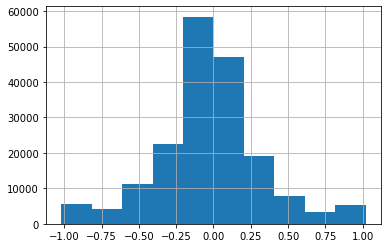

In [56]:
df_clean['steering'].hist()

In [55]:
# Split training and validation samples
train_samples, validation_samples = train_test_split(df_clean, test_size=0.2)

# Set batch size
batch_size=512

# compile and train the model using the generator function
train_generator = Generator(train_samples, batch_size)
validation_generator = Generator(validation_samples, batch_size)

In [59]:
# Resume training
stopper = EarlyStopping(monitor='loss', min_delta=0.0003, patience=5)

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history_fine_tune = model.fit(train_generator, 
    steps_per_epoch=np.ceil(len(train_samples)/batch_size),
    validation_data=validation_generator,
    validation_steps=np.ceil(len(validation_samples)/batch_size),
    epochs=30,
    callbacks=[stopper])

Epoch 1/30
289/289 [==============================] - 281s 973ms/step - loss: 0.0198 - acc: 0.0445 - val_loss: 0.0147 - val_acc: 0.0443
Epoch 2/30
289/289 [==============================] - 270s 935ms/step - loss: 0.0188 - acc: 0.0444 - val_loss: 0.0153 - val_acc: 0.0440
Epoch 3/30
289/289 [==============================] - 273s 943ms/step - loss: 0.0180 - acc: 0.0445 - val_loss: 0.0139 - val_acc: 0.0442
Epoch 4/30
289/289 [==============================] - 274s 946ms/step - loss: 0.0175 - acc: 0.0445 - val_loss: 0.0134 - val_acc: 0.0441
Epoch 5/30
289/289 [==============================] - 269s 930ms/step - loss: 0.0172 - acc: 0.0444 - val_loss: 0.0137 - val_acc: 0.0441
Epoch 6/30
289/289 [==============================] - 271s 936ms/step - loss: 0.0168 - acc: 0.0445 - val_loss: 0.0134 - val_acc: 0.0441
Epoch 7/30
289/289 [==============================] - 274s 947ms/step - loss: 0.0165 - acc: 0.0445 - val_loss: 0.0137 - val_acc: 0.0442
Epoch 8/30
289/289 [============================

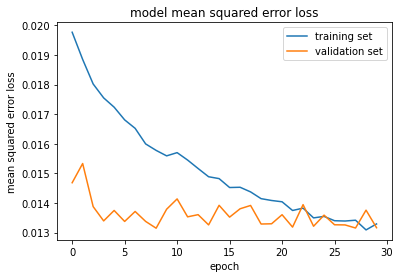

In [60]:
plt.plot(history_fine_tune.history['loss'])
plt.plot(history_fine_tune.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [61]:
model.save('model_tuned.h5')